In [4]:
!pip install mir_eval
!pip install nussl
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100720 sha256=fb6122e5dc72d9eb9f3dc8979b4f9b7b1e65a4eef5262a5854212b1d29bdf8e0
  Stored in directory: /root/.cache/pip/wheels/20/53/83/1d50d15a666140d53eda589db005f7cb53b739c7e54711f51f
Successfully built mir_eval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import numpy as np
import mir_eval
from scipy import signal
import librosa
import nussl
from scipy.signal import butter, filtfilt,sosfilt
from os import path
from pydub import AudioSegment
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

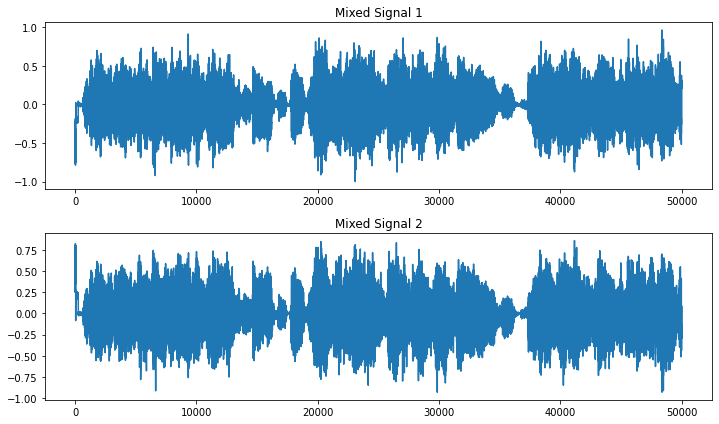

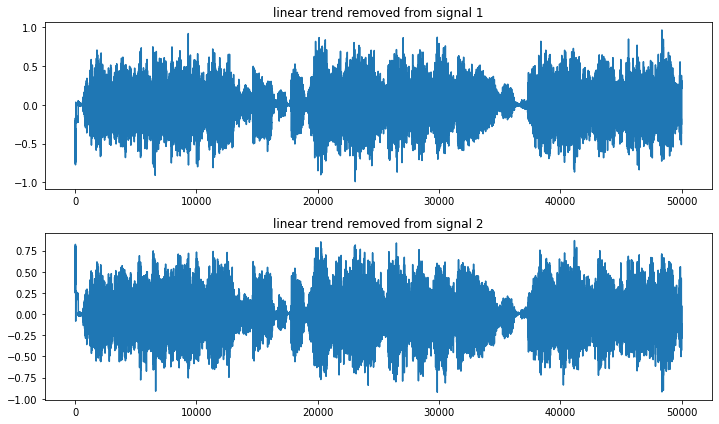

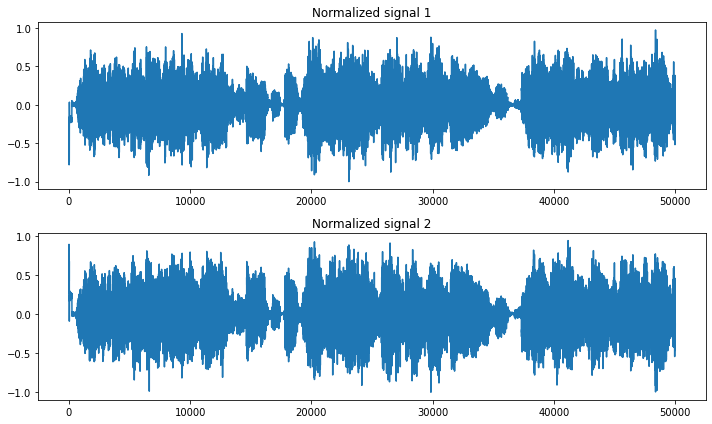

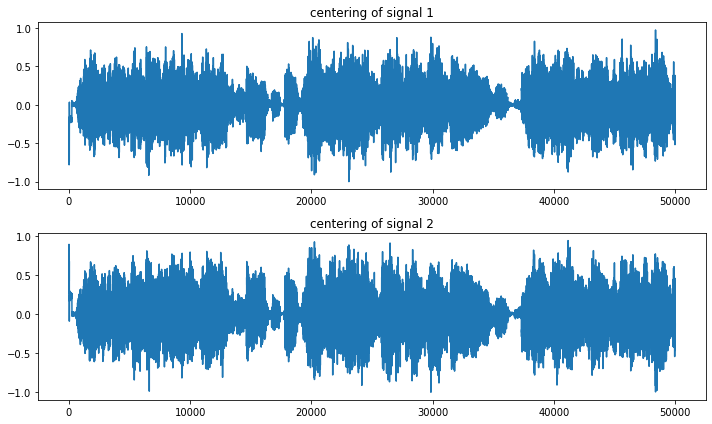

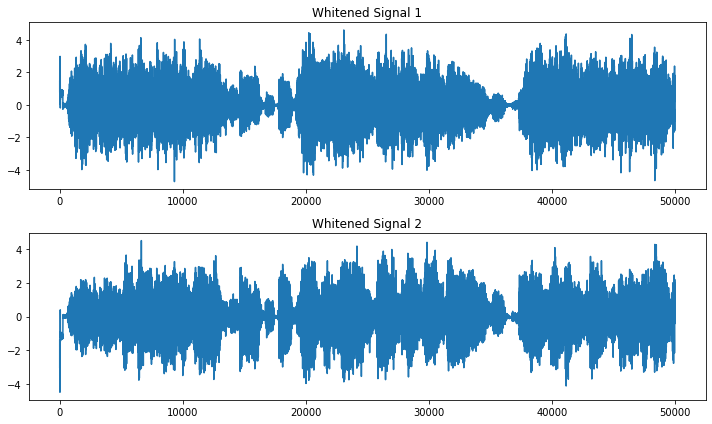

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


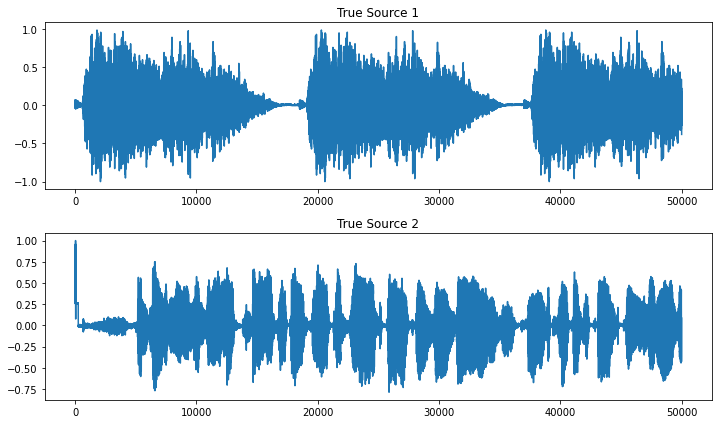

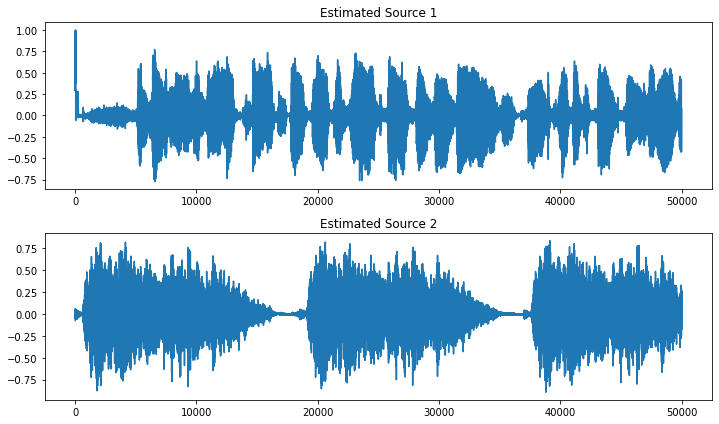

Separation Ratio: 0.8792439699172974
Source  Variance: 0.04471810162067413
estimated Source  Variance: 0.03591588884592056
Signal to Distortion Ratio (SDR) metric: [1.74344486]
Source to Interference Ratios (SIR) metric: [inf]
Sources to Artifacts Ratios metric (SAR): [1.74344486]
 compute_permutation (PERM) metric: [0]


In [27]:
# convert mp3 file to wav file
src = "mix1.mp3"
dst = "mixed_audio1.wav"

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

# convert mp3 file to wav file
src = "mix2.mp3"
dst = "mixed_audio2.wav"

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

# Load mixed audio signal
audio_signal = nussl.AudioSignal('mixed_audio1.wav')

# find the number of sources in mixed audio signal using Repet-SIM algorithm
separator = nussl.separation.primitive.RepetSim(audio_signal)
estimates = separator()

# the number of sources to separate
n_sources=len(estimates)

# Load the mixed audio signals
mixed_signal1, sr = librosa.load('mixed_audio1.wav', sr=None)
mixed_signal2, sr = librosa.load('mixed_audio2.wav', sr=None)

# Plot the mixed signals separately
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(mixed_signal1)
axs[0].set_title('Mixed Signal 1')
axs[1].plot(mixed_signal2)
axs[1].set_title('Mixed Signal 2')
plt.tight_layout()
plt.show()

# Apply pre-processing to the mixed signals
mixed_signal1 = signal.detrend(mixed_signal1)  # Remove linear trend
mixed_signal2 = signal.detrend(mixed_signal2)  # Remove linear trend

# Plot the linear trend removed signals separately
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(mixed_signal1)
axs[0].set_title('linear trend removed from signal 1')
axs[1].plot(mixed_signal2)
axs[1].set_title('linear trend removed from signal 2')
plt.tight_layout()
plt.show()

mixed_signal1 /= np.max(np.abs(mixed_signal1))  # Normalize to [-1, 1]
mixed_signal2 /= np.max(np.abs(mixed_signal2))  # Normalize to [-1, 1]

# Plot the Normalized signals separately
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(mixed_signal1)
axs[0].set_title('Normalized signal 1')
axs[1].plot(mixed_signal2)
axs[1].set_title('Normalized signal 2')
plt.tight_layout()
plt.show()

# Center the mixed signals (centering)
mixed_signal1 -= np.mean(mixed_signal1)
mixed_signal2 -= np.mean(mixed_signal2)

# Plot centering of signals separately
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(mixed_signal1)
axs[0].set_title('centering of signal 1')
axs[1].plot(mixed_signal2)
axs[1].set_title('centering of signal 2')
plt.tight_layout()
plt.show()

# Compute the covariance matrix of the mixed signals
cov_mat = np.cov(np.vstack((mixed_signal1, mixed_signal2)))

# Compute the eigenvalues and eigenvectors of the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Stack the signals into a single matrix
mixed_signal = np.vstack((mixed_signal1, mixed_signal2)).T

# Whiten the mixed signals
whitened = np.dot(np.dot(np.linalg.inv(np.sqrt(np.diag(eig_vals))), eig_vecs.T), mixed_signal.T).T

# Plot the whitened signals separately
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(whitened[:, 0])
axs[0].set_title('Whitened Signal 1')
axs[1].plot(whitened[:, 1])
axs[1].set_title('Whitened Signal 2')
plt.tight_layout()
plt.show()

# Apply FastICA to estimate the independent sources
ica = FastICA(n_components=n_sources, max_iter=2000)
est_sources = ica.fit_transform(mixed_signal)

# # Apply noise reduction using soft thresholding
# threshold = np.std(est_sources1) * 0.2
# est_sources = np.copy(est_sources1)
# est_sources[np.abs(est_sources1) < threshold] = 0

# Load the true sources
true_source1, sr = librosa.load('true_source1.wav', sr=None)
true_source2, sr = librosa.load('true_source2.wav', sr=None)

# Apply pre-processing to the true sources
true_source1 = signal.detrend(true_source1)  # Remove linear trend
true_source2 = signal.detrend(true_source2)  # Remove linear trend
true_source1 /= np.max(np.abs(true_source1))  # Normalize to [-1, 1]
true_source2 /= np.max(np.abs(true_source2))  # Normalize to [-1, 1]
mixed_signal1 -= np.mean(mixed_signal1)  #center
mixed_signal2 -= np.mean(mixed_signal2)  #center

# Plot the true sources
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(true_source1)
axs[0].set_title('True Source 1')
axs[1].plot(true_source2)
axs[1].set_title('True Source 2')
plt.tight_layout()
plt.show()

# Stack the true sources into a single matrix
true_sources = np.vstack((true_source1.T, true_source2)).T

# Apply post-processing to the estimated sources
est_sources /= np.max(np.abs(est_sources))  # Normalize to [-1, 1]

# Save the estimated sources to separate audio files
for i in range(n_sources):
    # librosa.(f'estimated_source_{i}.wav', est_sources[:, i], sr, norm=True)
    sf.write(f'estimated_source_{i}.wav', est_sources[:, i], sr)

# Plot the estimated sources
fig, axs = plt.subplots(n_sources, 1, figsize=(10, 3*n_sources))
for i in range(n_sources):
    axs[i].plot(est_sources[:, i])
    axs[i].set_title(f'Estimated Source {i+1}')
plt.tight_layout()
plt.show()

# Evaluate the performance of the separation
mir_eval.separation.MAX_SOURCES=100
true_sources=np.squeeze(true_sources.reshape(-1,1))
est_sources=np.squeeze(est_sources.reshape(-1,1))
snr, sir, sar, perm = mir_eval.separation.bss_eval_sources(true_sources,est_sources)

# Calculate the variance of the estimated sources
est_sources_var = np.var(est_sources)
# Calculate the variance of the true sources
true_sources_var = np.var(true_sources,axis=0)
# Calculate the variance of the mixed signals
mixed_signal_var = np.var(np.vstack((mixed_signal1, mixed_signal2)).T)
# Calculate the separation ratio
separation_ratio = np.sqrt(est_sources_var / mixed_signal_var)

# print the results
print(f"Separation Ratio: {separation_ratio}")
print(f"Source  Variance: {true_sources_var}")
print(f"estimated Source  Variance: {est_sources_var}")
print(f"Signal to Distortion Ratio (SDR) metric: {snr}")
print(f"Source to Interference Ratios (SIR) metric: {sir}")
print(f"Sources to Artifacts Ratios metric (SAR): {sar}")
print(f" compute_permutation (PERM) metric: {perm}")

In [28]:
ipd.Audio('estimated_source_1.wav')

In [29]:
ipd.Audio('estimated_source_0.wav')